In [1]:
from google.colab import drive

# The following command will prompt a URL for you to click and obtain the
# authorization code

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
from pathlib import Path

# Change this to where you put your hw1 files
DATA = Path("/content/drive/MyDrive/Fed_unchanged/FedPD/Python")

In [3]:
import os
import copy
import time
import pickle
import numpy as np
from tqdm import tqdm

import torch
from torch import nn

torch.manual_seed(0)

In [4]:
os.chdir(DATA / 'src')
from options import args_parser
from update import LocalUpdate, test_inference
from models import MLP, CNNMnist, CNNFashion_Mnist, CNNCifar, CNNFEMnist
from utils import get_dataset, average_weights, exp_details
from agent import Agent

In [5]:
class arg:
  def __init__(self):
    self.epochs = 200 #changed from 1000 
    self.freq_in = 300 
    self.freq_out = 1 
    self.num_users = 30 # changed from 90
    self.partial_users = 10
    self.local_ep = 300
    self.local_bs = 2
    self.lr = 0.01
    self.mu = 1
    self.dataset = 'femnist'
    self.VR = False
    self.model = 'cnn' 
    self.optimizer = 'FedDR' 
    self.gpu = False
args = arg()

In [6]:
# This cell is to load FeMNIST data
path_project = os.path.abspath('..')
if args.gpu:
        torch.cuda.set_device(args.gpu)
device = 'cuda' if args.gpu else 'cpu'

# load dataset and user groups
train_dataset, test_dataset, user_groups = get_dataset(args)

using femnist


In [7]:
import json
data_dir = '../data/femnist/'+'/train'
files = os.listdir(data_dir)
file_path = os.path.join(data_dir,files[0])
with open(file_path, 'r') as inf:
            cdata = json.load(inf)
from collections import defaultdict
data = defaultdict(lambda : None)
data.update(cdata['user_data'])

global_model = CNNFEMnist(args=args)
# global_model = MLP(75264,274,62)
global_model.train()

CNNFEMnist(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=3136, out_features=2048, bias=True)
    (1): ReLU()
  )
  (fc): Linear(in_features=2048, out_features=62, bias=True)
)

In [8]:
agent_list = []
for i in range(args.num_users):
    agent_list.append(Agent(global_model,args,i, nn.NLLLoss().to(device)))

# copy weights
global_weights = global_model.state_dict()

In [9]:
train_loss, train_accuracy = [], []
val_acc_list, net_list = [], []
cv_loss, cv_acc = [], []
print_every = 1
val_loss_pre, counter = 0, 0

In [10]:
import random
random.seed(10)
global_dict = {}
for epoch in tqdm(range(args.epochs)):
  local_weights = []
  print(f'\n | Global Training Round : {epoch+1} |\n')

  m = args.num_users
  if epoch % args.freq_out ==0:
      compute_full = True
      update_model = True
  else:
      compute_full = False
      update_model = False
  global_model.train()

  if epoch == 0:
    for idx in range(args.num_users):
      global_dict[str(idx)] = global_model.state_dict()

  S = [str(i) for i in random.sample(range(args.num_users),args.partial_users)]

  for idx in S:
      w= agent_list[int(idx)].train_(global_model.state_dict(), args.freq_in, train_dataset, user_groups, update_model, compute_full)
      # print(w['layer3.0.bias'])
      local_weights.append(copy.deepcopy(w))
      global_dict[idx] = local_weights[-1]
  # for idx in range(args.num_users):
  #     print(local_weights[idx]['layer3.0.bias'])


  if S:
      w_avg = copy.deepcopy(local_weights[0])
      w_avg = {key: w_avg[key]-w_avg[key] for key in w_avg.keys()}
      for key in w_avg.keys():
          for i in range(args.num_users):
              w_avg[key].add_(global_dict[str(i)][key])
          w_avg[key].div_(args.num_users)
  # print(w_avg['layer3.0.bias'])

  # update global weights
      global_weights = w_avg

  # update global weights
      global_model.load_state_dict(global_weights)
  # print(global_model)

  # Calculate avg training accuracy over all users at every epoch
  global_model.eval()
  test_acc, test_loss = test_inference(args, global_model, test_dataset)
  train_accuracy.append(test_acc)
  train_loss.append(test_loss)

  # print global training loss after every 'i' rounds
  if (epoch+1) % print_every == 0:
      print(f' \nAvg Training Stats after {epoch+1} global rounds:')
      print(f'Training Loss : {np.mean(np.array(train_loss))}')
      print('Train Accuracy: {:.2f}% \n'.format(100*train_accuracy[-1]),flush=True)

  0%|          | 0/200 [00:00<?, ?it/s]


 | Global Training Round : 1 |



/content/drive/MyDrive/Fed_unchanged/FedPD/Python/src/agent.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image,dtype=torch.float32), torch.tensor(label)
/content/drive/MyDrive/Fed_unchanged/FedPD/Python/src/optimizer.py:253: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  p.data.add_(-group['lr'], d_p+(p.data - lamb)*mu)


 
Avg Training Stats after 1 global rounds:
Training Loss : 111.50205492973328
Train Accuracy: 3.86% 



  0%|          | 1/200 [02:55<9:42:08, 175.52s/it]


 | Global Training Round : 2 |

 
Avg Training Stats after 2 global rounds:
Training Loss : 108.55568253993988
Train Accuracy: 5.31% 



  1%|          | 2/200 [05:51<9:40:07, 175.80s/it]


 | Global Training Round : 3 |

 
Avg Training Stats after 3 global rounds:
Training Loss : 107.55637216567993
Train Accuracy: 5.31% 



  2%|▏         | 3/200 [08:46<9:35:39, 175.33s/it]


 | Global Training Round : 4 |

 
Avg Training Stats after 4 global rounds:
Training Loss : 106.97897481918335
Train Accuracy: 5.31% 



  2%|▏         | 4/200 [11:40<9:31:52, 175.06s/it]


 | Global Training Round : 5 |

 
Avg Training Stats after 5 global rounds:
Training Loss : 106.55237855911255
Train Accuracy: 5.31% 



  2%|▎         | 5/200 [14:32<9:24:32, 173.71s/it]


 | Global Training Round : 6 |

 
Avg Training Stats after 6 global rounds:
Training Loss : 106.30106675624847
Train Accuracy: 5.31% 



  3%|▎         | 6/200 [17:24<9:19:53, 173.16s/it]


 | Global Training Round : 7 |

 
Avg Training Stats after 7 global rounds:
Training Loss : 106.14122005871364
Train Accuracy: 7.36% 



  4%|▎         | 7/200 [20:14<9:14:19, 172.33s/it]


 | Global Training Round : 8 |

 
Avg Training Stats after 8 global rounds:
Training Loss : 106.02605354785919
Train Accuracy: 5.26% 



  4%|▍         | 8/200 [23:05<9:09:58, 171.87s/it]


 | Global Training Round : 9 |

 
Avg Training Stats after 9 global rounds:
Training Loss : 105.94433683819241
Train Accuracy: 5.26% 



  4%|▍         | 9/200 [25:58<9:07:49, 172.09s/it]


 | Global Training Round : 10 |

 
Avg Training Stats after 10 global rounds:
Training Loss : 105.89743440151214
Train Accuracy: 5.26% 



  5%|▌         | 10/200 [28:49<9:04:11, 171.85s/it]


 | Global Training Round : 11 |

 
Avg Training Stats after 11 global rounds:
Training Loss : 105.82624819061972
Train Accuracy: 7.22% 



  6%|▌         | 11/200 [31:41<9:01:29, 171.90s/it]


 | Global Training Round : 12 |

 
Avg Training Stats after 12 global rounds:
Training Loss : 105.78061304489772
Train Accuracy: 5.31% 



  6%|▌         | 12/200 [34:32<8:57:14, 171.46s/it]


 | Global Training Round : 13 |

 
Avg Training Stats after 13 global rounds:
Training Loss : 105.75627961525551
Train Accuracy: 5.31% 



  6%|▋         | 13/200 [37:27<8:58:00, 172.62s/it]


 | Global Training Round : 14 |

 
Avg Training Stats after 14 global rounds:
Training Loss : 105.71753573417664
Train Accuracy: 5.31% 



  7%|▋         | 14/200 [40:19<8:54:27, 172.40s/it]


 | Global Training Round : 15 |

 
Avg Training Stats after 15 global rounds:
Training Loss : 105.6761197090149
Train Accuracy: 5.31% 



  8%|▊         | 15/200 [43:14<8:53:47, 173.12s/it]


 | Global Training Round : 16 |

 
Avg Training Stats after 16 global rounds:
Training Loss : 105.62806187570095
Train Accuracy: 5.31% 



  8%|▊         | 16/200 [46:07<8:51:13, 173.23s/it]


 | Global Training Round : 17 |

 
Avg Training Stats after 17 global rounds:
Training Loss : 105.58597925130059
Train Accuracy: 5.34% 



  8%|▊         | 17/200 [49:05<8:52:55, 174.73s/it]


 | Global Training Round : 18 |

 
Avg Training Stats after 18 global rounds:
Training Loss : 105.54874245325725
Train Accuracy: 5.31% 



  9%|▉         | 18/200 [52:01<8:50:47, 174.98s/it]


 | Global Training Round : 19 |

 
Avg Training Stats after 19 global rounds:
Training Loss : 105.50519108772278
Train Accuracy: 6.52% 



 10%|▉         | 19/200 [55:02<8:52:59, 176.68s/it]


 | Global Training Round : 20 |

 
Avg Training Stats after 20 global rounds:
Training Loss : 105.46009341478347
Train Accuracy: 10.88% 



 10%|█         | 20/200 [57:57<8:48:30, 176.17s/it]


 | Global Training Round : 21 |

 
Avg Training Stats after 21 global rounds:
Training Loss : 105.44189840271359
Train Accuracy: 5.31% 



 10%|█         | 21/200 [1:00:55<8:47:27, 176.80s/it]


 | Global Training Round : 22 |

 
Avg Training Stats after 22 global rounds:
Training Loss : 105.4138173081658
Train Accuracy: 9.93% 



 11%|█         | 22/200 [1:03:50<8:43:21, 176.41s/it]


 | Global Training Round : 23 |

 
Avg Training Stats after 23 global rounds:
Training Loss : 105.38662710397139
Train Accuracy: 5.31% 



 12%|█▏        | 23/200 [1:06:50<8:43:02, 177.30s/it]


 | Global Training Round : 24 |

 
Avg Training Stats after 24 global rounds:
Training Loss : 105.35072269042332
Train Accuracy: 9.29% 



 12%|█▏        | 24/200 [1:09:45<8:38:16, 176.69s/it]


 | Global Training Round : 25 |

 
Avg Training Stats after 25 global rounds:
Training Loss : 105.320123128891
Train Accuracy: 9.71% 



 12%|█▎        | 25/200 [1:12:45<8:38:09, 177.66s/it]


 | Global Training Round : 26 |

 
Avg Training Stats after 26 global rounds:
Training Loss : 105.29211624769064
Train Accuracy: 11.13% 



 13%|█▎        | 26/200 [1:15:43<8:35:16, 177.68s/it]


 | Global Training Round : 27 |

 
Avg Training Stats after 27 global rounds:
Training Loss : 105.27099336518182
Train Accuracy: 9.85% 



 14%|█▎        | 27/200 [1:18:42<8:34:08, 178.31s/it]


 | Global Training Round : 28 |

 
Avg Training Stats after 28 global rounds:
Training Loss : 105.24887286765235
Train Accuracy: 5.51% 



 14%|█▍        | 28/200 [1:21:37<8:28:07, 177.25s/it]


 | Global Training Round : 29 |

 
Avg Training Stats after 29 global rounds:
Training Loss : 105.23005502799461
Train Accuracy: 10.01% 



 14%|█▍        | 29/200 [1:24:38<8:28:05, 178.28s/it]


 | Global Training Round : 30 |

 
Avg Training Stats after 30 global rounds:
Training Loss : 105.20164715449015
Train Accuracy: 10.13% 



 15%|█▌        | 30/200 [1:27:32<8:21:35, 177.03s/it]


 | Global Training Round : 31 |

 
Avg Training Stats after 31 global rounds:
Training Loss : 105.16930802406803
Train Accuracy: 5.31% 



 16%|█▌        | 31/200 [1:30:30<8:19:31, 177.34s/it]


 | Global Training Round : 32 |

 
Avg Training Stats after 32 global rounds:
Training Loss : 105.14123307913542
Train Accuracy: 5.31% 



 16%|█▌        | 32/200 [1:33:23<8:13:14, 176.16s/it]


 | Global Training Round : 33 |

 
Avg Training Stats after 33 global rounds:
Training Loss : 105.12628522063747
Train Accuracy: 5.31% 



 16%|█▋        | 33/200 [1:36:21<8:11:45, 176.68s/it]


 | Global Training Round : 34 |

 
Avg Training Stats after 34 global rounds:
Training Loss : 105.10999115775613
Train Accuracy: 5.31% 



 17%|█▋        | 34/200 [1:39:15<8:06:17, 175.77s/it]


 | Global Training Round : 35 |

 
Avg Training Stats after 35 global rounds:
Training Loss : 105.08459526470729
Train Accuracy: 10.21% 



 18%|█▊        | 35/200 [1:42:13<8:05:04, 176.39s/it]


 | Global Training Round : 36 |

 
Avg Training Stats after 36 global rounds:
Training Loss : 105.05376601219177
Train Accuracy: 10.13% 



 18%|█▊        | 36/200 [1:45:07<8:00:34, 175.82s/it]


 | Global Training Round : 37 |

 
Avg Training Stats after 37 global rounds:
Training Loss : 105.02171573767791
Train Accuracy: 9.96% 



 18%|█▊        | 37/200 [1:48:04<7:58:26, 176.11s/it]


 | Global Training Round : 38 |

 
Avg Training Stats after 38 global rounds:
Training Loss : 104.98513787671139
Train Accuracy: 7.86% 



 19%|█▉        | 38/200 [1:50:57<7:52:54, 175.15s/it]


 | Global Training Round : 39 |

 
Avg Training Stats after 39 global rounds:
Training Loss : 104.95338089649493
Train Accuracy: 13.51% 



 20%|█▉        | 39/200 [1:53:55<7:52:06, 175.94s/it]


 | Global Training Round : 40 |

 
Avg Training Stats after 40 global rounds:
Training Loss : 104.92084231376649
Train Accuracy: 9.59% 



 20%|██        | 40/200 [1:56:51<7:49:17, 175.99s/it]


 | Global Training Round : 41 |

 
Avg Training Stats after 41 global rounds:
Training Loss : 104.88945380071314
Train Accuracy: 12.53% 



 20%|██        | 41/200 [1:59:50<7:48:46, 176.90s/it]


 | Global Training Round : 42 |

 
Avg Training Stats after 42 global rounds:
Training Loss : 104.85833380903516
Train Accuracy: 9.99% 



 21%|██        | 42/200 [2:02:45<7:44:00, 176.21s/it]


 | Global Training Round : 43 |

 
Avg Training Stats after 43 global rounds:
Training Loss : 104.82027900496195
Train Accuracy: 10.15% 



 22%|██▏       | 43/200 [2:05:41<7:41:31, 176.38s/it]


 | Global Training Round : 44 |

 
Avg Training Stats after 44 global rounds:
Training Loss : 104.78124309669842
Train Accuracy: 9.90% 



 22%|██▏       | 44/200 [2:08:35<7:36:34, 175.60s/it]


 | Global Training Round : 45 |

 
Avg Training Stats after 45 global rounds:
Training Loss : 104.74133408334521
Train Accuracy: 12.00% 



 22%|██▎       | 45/200 [2:11:34<7:36:10, 176.58s/it]


 | Global Training Round : 46 |

 
Avg Training Stats after 46 global rounds:
Training Loss : 104.69617873689403
Train Accuracy: 9.87% 



 23%|██▎       | 46/200 [2:14:30<7:32:49, 176.43s/it]


 | Global Training Round : 47 |

 
Avg Training Stats after 47 global rounds:
Training Loss : 104.65026928516144
Train Accuracy: 9.48% 



 24%|██▎       | 47/200 [2:17:27<7:30:31, 176.68s/it]


 | Global Training Round : 48 |

 
Avg Training Stats after 48 global rounds:
Training Loss : 104.59574123720328
Train Accuracy: 10.18% 



 24%|██▍       | 48/200 [2:20:21<7:25:34, 175.88s/it]


 | Global Training Round : 49 |

 
Avg Training Stats after 49 global rounds:
Training Loss : 104.53818576189937
Train Accuracy: 10.32% 



 24%|██▍       | 49/200 [2:23:19<7:24:21, 176.57s/it]


 | Global Training Round : 50 |

 
Avg Training Stats after 50 global rounds:
Training Loss : 104.47871486663819
Train Accuracy: 13.31% 



 25%|██▌       | 50/200 [2:26:15<7:20:39, 176.26s/it]


 | Global Training Round : 51 |

 
Avg Training Stats after 51 global rounds:
Training Loss : 104.41253365722358
Train Accuracy: 15.55% 



 26%|██▌       | 51/200 [2:29:13<7:18:44, 176.68s/it]


 | Global Training Round : 52 |

 
Avg Training Stats after 52 global rounds:
Training Loss : 104.33789771795273
Train Accuracy: 15.89% 



 26%|██▌       | 52/200 [2:32:07<7:13:49, 175.87s/it]


 | Global Training Round : 53 |

 
Avg Training Stats after 53 global rounds:
Training Loss : 104.2589911514858
Train Accuracy: 15.47% 



 26%|██▋       | 53/200 [2:35:04<7:11:42, 176.21s/it]


 | Global Training Round : 54 |

 
Avg Training Stats after 54 global rounds:
Training Loss : 104.17287513061807
Train Accuracy: 15.36% 



 27%|██▋       | 54/200 [2:37:59<7:07:47, 175.80s/it]


 | Global Training Round : 55 |

 
Avg Training Stats after 55 global rounds:
Training Loss : 104.07810696255078
Train Accuracy: 11.97% 



 28%|██▊       | 55/200 [2:40:58<7:07:10, 176.76s/it]


 | Global Training Round : 56 |

 
Avg Training Stats after 56 global rounds:
Training Loss : 103.97904956766537
Train Accuracy: 14.69% 



 28%|██▊       | 56/200 [2:43:52<7:02:38, 176.10s/it]


 | Global Training Round : 57 |

 
Avg Training Stats after 57 global rounds:
Training Loss : 103.86706491102252
Train Accuracy: 15.89% 



 28%|██▊       | 57/200 [2:46:52<7:02:31, 177.28s/it]


 | Global Training Round : 58 |

 
Avg Training Stats after 58 global rounds:
Training Loss : 103.73999112227867
Train Accuracy: 16.64% 



 29%|██▉       | 58/200 [2:49:47<6:58:09, 176.69s/it]


 | Global Training Round : 59 |

 
Avg Training Stats after 59 global rounds:
Training Loss : 103.59706783294678
Train Accuracy: 16.90% 



 30%|██▉       | 59/200 [2:52:46<6:56:29, 177.23s/it]


 | Global Training Round : 60 |

 
Avg Training Stats after 60 global rounds:
Training Loss : 103.43649837176005
Train Accuracy: 17.51% 



 30%|███       | 60/200 [2:55:41<6:51:49, 176.49s/it]


 | Global Training Round : 61 |

 
Avg Training Stats after 61 global rounds:
Training Loss : 103.25926613807678
Train Accuracy: 18.10% 



 30%|███       | 61/200 [2:58:40<6:50:55, 177.38s/it]


 | Global Training Round : 62 |

 
Avg Training Stats after 62 global rounds:
Training Loss : 103.06182700587857
Train Accuracy: 19.83% 



 31%|███       | 62/200 [3:01:36<6:47:09, 177.02s/it]


 | Global Training Round : 63 |

 
Avg Training Stats after 63 global rounds:
Training Loss : 102.85374357965257
Train Accuracy: 22.80% 



 32%|███▏      | 63/200 [3:04:35<6:45:23, 177.55s/it]


 | Global Training Round : 64 |

 
Avg Training Stats after 64 global rounds:
Training Loss : 102.63151112571359
Train Accuracy: 22.49% 



 32%|███▏      | 64/200 [3:07:29<6:40:16, 176.59s/it]


 | Global Training Round : 65 |

 
Avg Training Stats after 65 global rounds:
Training Loss : 102.39493561524611
Train Accuracy: 24.45% 



 32%|███▎      | 65/200 [3:10:30<6:39:43, 177.66s/it]


 | Global Training Round : 66 |

 
Avg Training Stats after 66 global rounds:
Training Loss : 102.15451326875976
Train Accuracy: 26.66% 



 33%|███▎      | 66/200 [3:13:27<6:36:22, 177.48s/it]


 | Global Training Round : 67 |

 
Avg Training Stats after 67 global rounds:
Training Loss : 101.90855541869776
Train Accuracy: 26.27% 



 34%|███▎      | 67/200 [3:16:26<6:34:51, 178.13s/it]


 | Global Training Round : 68 |

 
Avg Training Stats after 68 global rounds:
Training Loss : 101.65273751581417
Train Accuracy: 25.62% 



 34%|███▍      | 68/200 [3:19:21<6:29:36, 177.10s/it]


 | Global Training Round : 69 |

 
Avg Training Stats after 69 global rounds:
Training Loss : 101.37891113930854
Train Accuracy: 27.47% 



 34%|███▍      | 69/200 [3:22:20<6:28:07, 177.77s/it]


 | Global Training Round : 70 |

 
Avg Training Stats after 70 global rounds:
Training Loss : 101.08679543222699
Train Accuracy: 28.64% 



 35%|███▌      | 70/200 [3:25:15<6:23:17, 176.91s/it]


 | Global Training Round : 71 |

 
Avg Training Stats after 71 global rounds:
Training Loss : 100.7854705427734
Train Accuracy: 30.66% 



 36%|███▌      | 71/200 [3:28:15<6:22:05, 177.72s/it]


 | Global Training Round : 72 |

 
Avg Training Stats after 72 global rounds:
Training Loss : 100.47288431392775
Train Accuracy: 33.62% 



 36%|███▌      | 72/200 [3:31:11<6:18:06, 177.24s/it]


 | Global Training Round : 73 |

 
Avg Training Stats after 73 global rounds:
Training Loss : 100.1563982538981
Train Accuracy: 33.79% 



 36%|███▋      | 73/200 [3:34:11<6:16:40, 177.96s/it]


 | Global Training Round : 74 |

 
Avg Training Stats after 74 global rounds:
Training Loss : 99.83743831273672
Train Accuracy: 35.30% 



 37%|███▋      | 74/200 [3:37:07<6:12:32, 177.40s/it]


 | Global Training Round : 75 |

 
Avg Training Stats after 75 global rounds:
Training Loss : 99.51253806432088
Train Accuracy: 35.97% 



 38%|███▊      | 75/200 [3:40:04<6:09:48, 177.51s/it]


 | Global Training Round : 76 |

 
Avg Training Stats after 76 global rounds:
Training Loss : 99.17878552800731
Train Accuracy: 35.69% 



 38%|███▊      | 76/200 [3:43:00<6:05:54, 177.05s/it]


 | Global Training Round : 77 |

 
Avg Training Stats after 77 global rounds:
Training Loss : 98.84148474482747
Train Accuracy: 37.23% 



 38%|███▊      | 77/200 [3:46:01<6:04:51, 177.98s/it]


 | Global Training Round : 78 |

 
Avg Training Stats after 78 global rounds:
Training Loss : 98.49282117684682
Train Accuracy: 37.76% 



 39%|███▉      | 78/200 [3:48:56<6:00:26, 177.27s/it]


 | Global Training Round : 79 |

 
Avg Training Stats after 79 global rounds:
Training Loss : 98.14042488834527
Train Accuracy: 38.91% 



 40%|███▉      | 79/200 [3:51:56<5:59:11, 178.11s/it]


 | Global Training Round : 80 |

 
Avg Training Stats after 80 global rounds:
Training Loss : 97.78452895581722
Train Accuracy: 39.80% 



 40%|████      | 80/200 [3:54:53<5:55:36, 177.81s/it]


 | Global Training Round : 81 |

 
Avg Training Stats after 81 global rounds:
Training Loss : 97.43335122826659
Train Accuracy: 39.55% 



 40%|████      | 81/200 [3:57:55<5:54:44, 178.86s/it]


 | Global Training Round : 82 |

 
Avg Training Stats after 82 global rounds:
Training Loss : 97.07318287070204
Train Accuracy: 42.29% 



 41%|████      | 82/200 [4:00:51<5:50:20, 178.14s/it]


 | Global Training Round : 83 |

 
Avg Training Stats after 83 global rounds:
Training Loss : 96.713005844369
Train Accuracy: 42.10% 



 42%|████▏     | 83/200 [4:03:50<5:48:01, 178.48s/it]


 | Global Training Round : 84 |

 
Avg Training Stats after 84 global rounds:
Training Loss : 96.3434428970019
Train Accuracy: 42.55% 



 42%|████▏     | 84/200 [4:06:46<5:43:36, 177.73s/it]


 | Global Training Round : 85 |

 
Avg Training Stats after 85 global rounds:
Training Loss : 95.97692000164704
Train Accuracy: 41.65% 



 42%|████▎     | 85/200 [4:09:45<5:41:17, 178.06s/it]


 | Global Training Round : 86 |

 
Avg Training Stats after 86 global rounds:
Training Loss : 95.60964857145797
Train Accuracy: 41.57% 



 43%|████▎     | 86/200 [4:12:41<5:36:48, 177.27s/it]


 | Global Training Round : 87 |

 
Avg Training Stats after 87 global rounds:
Training Loss : 95.2346885259124
Train Accuracy: 43.83% 



 44%|████▎     | 87/200 [4:15:40<5:35:05, 177.93s/it]


 | Global Training Round : 88 |

 
Avg Training Stats after 88 global rounds:
Training Loss : 94.86088132722811
Train Accuracy: 43.89% 



 44%|████▍     | 88/200 [4:18:35<5:30:37, 177.12s/it]


 | Global Training Round : 89 |

 
Avg Training Stats after 89 global rounds:
Training Loss : 94.485509335325
Train Accuracy: 45.96% 



 44%|████▍     | 89/200 [4:21:33<5:28:05, 177.35s/it]


 | Global Training Round : 90 |

 
Avg Training Stats after 90 global rounds:
Training Loss : 94.10734106169807
Train Accuracy: 47.30% 



 45%|████▌     | 90/200 [4:24:28<5:23:29, 176.45s/it]


 | Global Training Round : 91 |

 
Avg Training Stats after 91 global rounds:
Training Loss : 93.73514458373353
Train Accuracy: 45.99% 



 46%|████▌     | 91/200 [4:27:28<5:22:39, 177.61s/it]


 | Global Training Round : 92 |

 
Avg Training Stats after 92 global rounds:
Training Loss : 93.35161830938381
Train Accuracy: 47.80% 



 46%|████▌     | 92/200 [4:30:23<5:18:32, 176.96s/it]


 | Global Training Round : 93 |

 
Avg Training Stats after 93 global rounds:
Training Loss : 92.9694182859954
Train Accuracy: 48.87% 



 46%|████▋     | 93/200 [4:33:21<5:15:59, 177.19s/it]


 | Global Training Round : 94 |

 
Avg Training Stats after 94 global rounds:
Training Loss : 92.58495195114867
Train Accuracy: 49.68% 



 47%|████▋     | 94/200 [4:36:13<5:10:08, 175.55s/it]


 | Global Training Round : 95 |

 
Avg Training Stats after 95 global rounds:
Training Loss : 92.20088752821871
Train Accuracy: 49.51% 



 48%|████▊     | 95/200 [4:39:08<5:07:11, 175.54s/it]


 | Global Training Round : 96 |

 
Avg Training Stats after 96 global rounds:
Training Loss : 91.8177831582725
Train Accuracy: 51.13% 



 48%|████▊     | 96/200 [4:42:02<5:03:08, 174.89s/it]


 | Global Training Round : 97 |

 
Avg Training Stats after 97 global rounds:
Training Loss : 91.4333156470171
Train Accuracy: 51.86% 



 48%|████▊     | 97/200 [4:44:59<5:01:14, 175.49s/it]


 | Global Training Round : 98 |

 
Avg Training Stats after 98 global rounds:
Training Loss : 91.04778327747267
Train Accuracy: 52.25% 



 49%|████▉     | 98/200 [4:47:50<4:56:26, 174.38s/it]


 | Global Training Round : 99 |

 
Avg Training Stats after 99 global rounds:
Training Loss : 90.66357658126138
Train Accuracy: 52.64% 



 50%|████▉     | 99/200 [4:50:47<4:54:48, 175.14s/it]


 | Global Training Round : 100 |

 
Avg Training Stats after 100 global rounds:
Training Loss : 90.27643776297569
Train Accuracy: 53.57% 



 50%|█████     | 100/200 [4:53:41<4:51:12, 174.73s/it]


 | Global Training Round : 101 |

 
Avg Training Stats after 101 global rounds:
Training Loss : 89.8910550599051
Train Accuracy: 53.71% 



 50%|█████     | 101/200 [4:56:38<4:49:31, 175.47s/it]


 | Global Training Round : 102 |

 
Avg Training Stats after 102 global rounds:
Training Loss : 89.50489484562593
Train Accuracy: 53.99% 



 51%|█████     | 102/200 [4:59:31<4:45:03, 174.52s/it]


 | Global Training Round : 103 |

 
Avg Training Stats after 103 global rounds:
Training Loss : 89.11995341476884
Train Accuracy: 55.41% 



 52%|█████▏    | 103/200 [5:02:28<4:43:42, 175.49s/it]


 | Global Training Round : 104 |

 
Avg Training Stats after 104 global rounds:
Training Loss : 88.72987231841454
Train Accuracy: 55.80% 



 52%|█████▏    | 104/200 [5:05:24<4:40:41, 175.43s/it]


 | Global Training Round : 105 |

 
Avg Training Stats after 105 global rounds:
Training Loss : 88.34225011326018
Train Accuracy: 55.83% 



 52%|█████▎    | 105/200 [5:08:23<4:39:52, 176.76s/it]


 | Global Training Round : 106 |

 
Avg Training Stats after 106 global rounds:
Training Loss : 87.95581270163913
Train Accuracy: 56.14% 



 53%|█████▎    | 106/200 [5:11:17<4:35:29, 175.85s/it]


 | Global Training Round : 107 |

 
Avg Training Stats after 107 global rounds:
Training Loss : 87.5696316211023
Train Accuracy: 57.45% 



 54%|█████▎    | 107/200 [5:14:15<4:33:14, 176.29s/it]


 | Global Training Round : 108 |

 
Avg Training Stats after 108 global rounds:
Training Loss : 87.18662476318853
Train Accuracy: 58.32% 



 54%|█████▍    | 108/200 [5:17:07<4:28:39, 175.21s/it]


 | Global Training Round : 109 |

 
Avg Training Stats after 109 global rounds:
Training Loss : 86.80450434641007
Train Accuracy: 58.27% 



 55%|█████▍    | 109/200 [5:20:03<4:26:06, 175.46s/it]


 | Global Training Round : 110 |

 
Avg Training Stats after 110 global rounds:
Training Loss : 86.42419200702147
Train Accuracy: 58.57% 



 55%|█████▌    | 110/200 [5:22:56<4:22:09, 174.78s/it]


 | Global Training Round : 111 |

 
Avg Training Stats after 111 global rounds:
Training Loss : 86.04882040539303
Train Accuracy: 58.52% 



 56%|█████▌    | 111/200 [5:25:53<4:20:00, 175.29s/it]


 | Global Training Round : 112 |

 
Avg Training Stats after 112 global rounds:
Training Loss : 85.67296301254204
Train Accuracy: 60.11% 



 56%|█████▌    | 112/200 [5:28:45<4:15:53, 174.47s/it]


 | Global Training Round : 113 |

 
Avg Training Stats after 113 global rounds:
Training Loss : 85.30104628389915
Train Accuracy: 59.69% 



 56%|█████▋    | 113/200 [5:31:43<4:14:10, 175.29s/it]


 | Global Training Round : 114 |

 
Avg Training Stats after 114 global rounds:
Training Loss : 84.93174838706067
Train Accuracy: 59.94% 



 57%|█████▋    | 114/200 [5:34:35<4:10:10, 174.54s/it]


 | Global Training Round : 115 |

 
Avg Training Stats after 115 global rounds:
Training Loss : 84.56505627943122
Train Accuracy: 59.94% 



 57%|█████▊    | 115/200 [5:37:32<4:07:55, 175.01s/it]


 | Global Training Round : 116 |

 
Avg Training Stats after 116 global rounds:
Training Loss : 84.20030933515778
Train Accuracy: 60.42% 



 58%|█████▊    | 116/200 [5:40:24<4:03:47, 174.13s/it]


 | Global Training Round : 117 |

 
Avg Training Stats after 117 global rounds:
Training Loss : 83.83714493625185
Train Accuracy: 61.68% 



 58%|█████▊    | 117/200 [5:43:20<4:01:56, 174.90s/it]


 | Global Training Round : 118 |

 
Avg Training Stats after 118 global rounds:
Training Loss : 83.47265609240128
Train Accuracy: 62.80% 



 59%|█████▉    | 118/200 [5:46:15<3:58:52, 174.79s/it]


 | Global Training Round : 119 |

 
Avg Training Stats after 119 global rounds:
Training Loss : 83.10853715003037
Train Accuracy: 62.49% 



 60%|█████▉    | 119/200 [5:49:10<3:56:13, 174.98s/it]


 | Global Training Round : 120 |

 
Avg Training Stats after 120 global rounds:
Training Loss : 82.74492296079795
Train Accuracy: 62.99% 



 60%|██████    | 120/200 [5:52:03<3:52:29, 174.37s/it]


 | Global Training Round : 121 |

 
Avg Training Stats after 121 global rounds:
Training Loss : 82.38540957880414
Train Accuracy: 63.41% 



 60%|██████    | 121/200 [5:55:01<3:50:56, 175.39s/it]


 | Global Training Round : 122 |

 
Avg Training Stats after 122 global rounds:
Training Loss : 82.02978266164905
Train Accuracy: 64.14% 



 61%|██████    | 122/200 [5:57:54<3:46:58, 174.60s/it]


 | Global Training Round : 123 |

 
Avg Training Stats after 123 global rounds:
Training Loss : 81.67714383253237
Train Accuracy: 64.25% 



 62%|██████▏   | 123/200 [6:00:51<3:45:02, 175.36s/it]


 | Global Training Round : 124 |

 
Avg Training Stats after 124 global rounds:
Training Loss : 81.3266017581186
Train Accuracy: 64.62% 



 62%|██████▏   | 124/200 [6:03:43<3:40:48, 174.32s/it]


 | Global Training Round : 125 |

 
Avg Training Stats after 125 global rounds:
Training Loss : 80.97975973701477
Train Accuracy: 64.98% 



 62%|██████▎   | 125/200 [6:06:38<3:38:23, 174.72s/it]


 | Global Training Round : 126 |

 
Avg Training Stats after 126 global rounds:
Training Loss : 80.6335461130218
Train Accuracy: 65.26% 



 63%|██████▎   | 126/200 [6:09:30<3:34:25, 173.86s/it]


 | Global Training Round : 127 |

 
Avg Training Stats after 127 global rounds:
Training Loss : 80.29013714734025
Train Accuracy: 65.45% 



 64%|██████▎   | 127/200 [6:12:28<3:32:57, 175.04s/it]


 | Global Training Round : 128 |

 
Avg Training Stats after 128 global rounds:
Training Loss : 79.9492514487356
Train Accuracy: 65.87% 



 64%|██████▍   | 128/200 [6:15:21<3:29:22, 174.48s/it]


 | Global Training Round : 129 |

 
Avg Training Stats after 129 global rounds:
Training Loss : 79.61079113196956
Train Accuracy: 67.19% 



 64%|██████▍   | 129/200 [6:18:18<3:27:25, 175.29s/it]


 | Global Training Round : 130 |

 
Avg Training Stats after 130 global rounds:
Training Loss : 79.27557227473993
Train Accuracy: 67.05% 



 65%|██████▌   | 130/200 [6:21:10<3:23:16, 174.23s/it]


 | Global Training Round : 131 |

 
Avg Training Stats after 131 global rounds:
Training Loss : 78.94115710394983
Train Accuracy: 67.30% 



 66%|██████▌   | 131/200 [6:24:06<3:21:01, 174.80s/it]


 | Global Training Round : 132 |

 
Avg Training Stats after 132 global rounds:
Training Loss : 78.6097369537209
Train Accuracy: 67.94% 



 66%|██████▌   | 132/200 [6:27:00<3:17:43, 174.46s/it]


 | Global Training Round : 133 |

 
Avg Training Stats after 133 global rounds:
Training Loss : 78.27825093762318
Train Accuracy: 67.92% 



 66%|██████▋   | 133/200 [6:29:58<3:16:00, 175.53s/it]


 | Global Training Round : 134 |

 
Avg Training Stats after 134 global rounds:
Training Loss : 77.94796230054614
Train Accuracy: 68.06% 



 67%|██████▋   | 134/200 [6:32:49<3:11:38, 174.22s/it]


 | Global Training Round : 135 |

 
Avg Training Stats after 135 global rounds:
Training Loss : 77.61939914094077
Train Accuracy: 69.17% 



 68%|██████▊   | 135/200 [6:35:46<3:09:34, 174.99s/it]


 | Global Training Round : 136 |

 
Avg Training Stats after 136 global rounds:
Training Loss : 77.29312736321899
Train Accuracy: 69.15% 



 68%|██████▊   | 136/200 [6:38:37<3:05:28, 173.88s/it]


 | Global Training Round : 137 |

 
Avg Training Stats after 137 global rounds:
Training Loss : 76.97000393423721
Train Accuracy: 69.48% 



 68%|██████▊   | 137/200 [6:41:33<3:03:16, 174.54s/it]


 | Global Training Round : 138 |

 
Avg Training Stats after 138 global rounds:
Training Loss : 76.64939656076224
Train Accuracy: 69.57% 



 69%|██████▉   | 138/200 [6:44:27<2:59:58, 174.17s/it]


 | Global Training Round : 139 |

 
Avg Training Stats after 139 global rounds:
Training Loss : 76.33164025082004
Train Accuracy: 70.04% 



 70%|██████▉   | 139/200 [6:47:23<2:57:42, 174.80s/it]


 | Global Training Round : 140 |

 
Avg Training Stats after 140 global rounds:
Training Loss : 76.01723233035632
Train Accuracy: 69.76% 



 70%|███████   | 140/200 [6:50:17<2:54:34, 174.57s/it]


 | Global Training Round : 141 |

 
Avg Training Stats after 141 global rounds:
Training Loss : 75.70434387313558
Train Accuracy: 70.32% 



 70%|███████   | 141/200 [6:53:14<2:52:18, 175.23s/it]


 | Global Training Round : 142 |

 
Avg Training Stats after 142 global rounds:
Training Loss : 75.39338466567052
Train Accuracy: 70.49% 



 71%|███████   | 142/200 [6:56:07<2:48:52, 174.70s/it]


 | Global Training Round : 143 |

 
Avg Training Stats after 143 global rounds:
Training Loss : 75.08565049988407
Train Accuracy: 70.57% 



 72%|███████▏  | 143/200 [6:59:05<2:46:43, 175.51s/it]


 | Global Training Round : 144 |

 
Avg Training Stats after 144 global rounds:
Training Loss : 74.78095746123128
Train Accuracy: 71.36% 



 72%|███████▏  | 144/200 [7:01:57<2:42:58, 174.61s/it]


 | Global Training Round : 145 |

 
Avg Training Stats after 145 global rounds:
Training Loss : 74.47886656440538
Train Accuracy: 71.38% 



 72%|███████▎  | 145/200 [7:04:52<2:40:05, 174.64s/it]


 | Global Training Round : 146 |

 
Avg Training Stats after 146 global rounds:
Training Loss : 74.17667703963306
Train Accuracy: 71.47% 



 73%|███████▎  | 146/200 [7:07:44<2:36:29, 173.88s/it]


 | Global Training Round : 147 |

 
Avg Training Stats after 147 global rounds:
Training Loss : 73.87604088523761
Train Accuracy: 71.75% 



 74%|███████▎  | 147/200 [7:10:40<2:34:04, 174.42s/it]


 | Global Training Round : 148 |

 
Avg Training Stats after 148 global rounds:
Training Loss : 73.57765515108366
Train Accuracy: 71.69% 



 74%|███████▍  | 148/200 [7:13:33<2:30:58, 174.21s/it]


 | Global Training Round : 149 |

 
Avg Training Stats after 149 global rounds:
Training Loss : 73.281454859964
Train Accuracy: 72.00% 



 74%|███████▍  | 149/200 [7:16:28<2:28:11, 174.35s/it]


 | Global Training Round : 150 |

 
Avg Training Stats after 150 global rounds:
Training Loss : 72.98677648385366
Train Accuracy: 72.03% 



 75%|███████▌  | 150/200 [7:19:20<2:24:39, 173.59s/it]


 | Global Training Round : 151 |

 
Avg Training Stats after 151 global rounds:
Training Loss : 72.69445474929367
Train Accuracy: 72.59% 



 76%|███████▌  | 151/200 [7:22:15<2:22:12, 174.13s/it]


 | Global Training Round : 152 |

 
Avg Training Stats after 152 global rounds:
Training Loss : 72.4044825983675
Train Accuracy: 72.81% 



 76%|███████▌  | 152/200 [7:25:07<2:18:42, 173.38s/it]


 | Global Training Round : 153 |

 
Avg Training Stats after 153 global rounds:
Training Loss : 72.11507550563688
Train Accuracy: 73.79% 



 76%|███████▋  | 153/200 [7:28:02<2:16:16, 173.98s/it]


 | Global Training Round : 154 |

 
Avg Training Stats after 154 global rounds:
Training Loss : 71.82860727666261
Train Accuracy: 73.59% 



 77%|███████▋  | 154/200 [7:30:53<2:12:34, 172.92s/it]


 | Global Training Round : 155 |

 
Avg Training Stats after 155 global rounds:
Training Loss : 71.54403666950041
Train Accuracy: 73.96% 



 78%|███████▊  | 155/200 [7:33:48<2:10:09, 173.54s/it]


 | Global Training Round : 156 |

 
Avg Training Stats after 156 global rounds:
Training Loss : 71.26171390406596
Train Accuracy: 74.32% 



 78%|███████▊  | 156/200 [7:36:39<2:06:45, 172.86s/it]


 | Global Training Round : 157 |

 
Avg Training Stats after 157 global rounds:
Training Loss : 70.9816026095372
Train Accuracy: 74.29% 



 78%|███████▊  | 157/200 [7:39:35<2:04:29, 173.72s/it]


 | Global Training Round : 158 |

 
Avg Training Stats after 158 global rounds:
Training Loss : 70.70370712763146
Train Accuracy: 73.82% 



 79%|███████▉  | 158/200 [7:42:25<2:00:54, 172.73s/it]


 | Global Training Round : 159 |

 
Avg Training Stats after 159 global rounds:
Training Loss : 70.4294998252167
Train Accuracy: 73.71% 



 80%|███████▉  | 159/200 [7:45:22<1:58:50, 173.91s/it]


 | Global Training Round : 160 |

 
Avg Training Stats after 160 global rounds:
Training Loss : 70.15625907741487
Train Accuracy: 74.29% 



 80%|████████  | 160/200 [7:48:14<1:55:30, 173.27s/it]


 | Global Training Round : 161 |

 
Avg Training Stats after 161 global rounds:
Training Loss : 69.88395455720261
Train Accuracy: 74.74% 



 80%|████████  | 161/200 [7:51:06<1:52:29, 173.05s/it]


 | Global Training Round : 162 |

 
Avg Training Stats after 162 global rounds:
Training Loss : 69.61290000287103
Train Accuracy: 74.80% 



 81%|████████  | 162/200 [7:54:02<1:50:04, 173.79s/it]


 | Global Training Round : 163 |

 
Avg Training Stats after 163 global rounds:
Training Loss : 69.34377197473327
Train Accuracy: 75.02% 



 82%|████████▏ | 163/200 [7:56:54<1:46:51, 173.28s/it]


 | Global Training Round : 164 |

 
Avg Training Stats after 164 global rounds:
Training Loss : 69.07510775109617
Train Accuracy: 75.24% 



 82%|████████▏ | 164/200 [7:59:49<1:44:22, 173.97s/it]


 | Global Training Round : 165 |

 
Avg Training Stats after 165 global rounds:
Training Loss : 68.80955533258843
Train Accuracy: 75.44% 



 82%|████████▎ | 165/200 [8:02:39<1:40:40, 172.58s/it]


 | Global Training Round : 166 |

 
Avg Training Stats after 166 global rounds:
Training Loss : 68.5479550544756
Train Accuracy: 75.16% 



 83%|████████▎ | 166/200 [8:05:34<1:38:15, 173.40s/it]


 | Global Training Round : 167 |

 
Avg Training Stats after 167 global rounds:
Training Loss : 68.28722152488675
Train Accuracy: 75.86% 



 84%|████████▎ | 167/200 [8:08:25<1:35:01, 172.79s/it]


 | Global Training Round : 168 |

 
Avg Training Stats after 168 global rounds:
Training Loss : 68.02851052085559
Train Accuracy: 76.06% 



 84%|████████▍ | 168/200 [8:11:23<1:32:53, 174.18s/it]


 | Global Training Round : 169 |

 
Avg Training Stats after 169 global rounds:
Training Loss : 67.7724706749239
Train Accuracy: 75.64% 



 84%|████████▍ | 169/200 [8:14:15<1:29:42, 173.64s/it]


 | Global Training Round : 170 |

 
Avg Training Stats after 170 global rounds:
Training Loss : 67.51757585651734
Train Accuracy: 75.97% 



 85%|████████▌ | 170/200 [8:17:10<1:27:04, 174.16s/it]


 | Global Training Round : 171 |

 
Avg Training Stats after 171 global rounds:
Training Loss : 67.26683847597468
Train Accuracy: 75.72% 



 86%|████████▌ | 171/200 [8:20:04<1:24:08, 174.08s/it]


 | Global Training Round : 172 |

 
Avg Training Stats after 172 global rounds:
Training Loss : 67.01724445577278
Train Accuracy: 75.80% 



 86%|████████▌ | 172/200 [8:22:57<1:21:05, 173.78s/it]


 | Global Training Round : 173 |

 
Avg Training Stats after 173 global rounds:
Training Loss : 66.7693919756509
Train Accuracy: 76.00% 



 86%|████████▋ | 173/200 [8:25:49<1:17:50, 172.97s/it]


 | Global Training Round : 174 |

 
Avg Training Stats after 174 global rounds:
Training Loss : 66.52290183065952
Train Accuracy: 76.34% 



 87%|████████▋ | 174/200 [8:28:43<1:15:06, 173.34s/it]


 | Global Training Round : 175 |

 
Avg Training Stats after 175 global rounds:
Training Loss : 66.27829533032009
Train Accuracy: 76.70% 



 88%|████████▊ | 175/200 [8:31:34<1:11:56, 172.64s/it]


 | Global Training Round : 176 |

 
Avg Training Stats after 176 global rounds:
Training Loss : 66.0360567630692
Train Accuracy: 76.34% 



 88%|████████▊ | 176/200 [8:34:24<1:08:49, 172.06s/it]


 | Global Training Round : 177 |

 
Avg Training Stats after 177 global rounds:
Training Loss : 65.79444462801777
Train Accuracy: 76.76% 



 88%|████████▊ | 177/200 [8:37:17<1:06:00, 172.19s/it]


 | Global Training Round : 178 |

 
Avg Training Stats after 178 global rounds:
Training Loss : 65.55370209156797
Train Accuracy: 77.12% 



 89%|████████▉ | 178/200 [8:40:08<1:02:59, 171.79s/it]


 | Global Training Round : 179 |

 
Avg Training Stats after 179 global rounds:
Training Loss : 65.3143620284576
Train Accuracy: 77.48% 



 90%|████████▉ | 179/200 [8:43:00<1:00:11, 171.95s/it]


 | Global Training Round : 180 |

 
Avg Training Stats after 180 global rounds:
Training Loss : 65.07780854139062
Train Accuracy: 77.85% 



 90%|█████████ | 180/200 [8:45:51<57:14, 171.71s/it]  


 | Global Training Round : 181 |

 
Avg Training Stats after 181 global rounds:
Training Loss : 64.8435123569399
Train Accuracy: 77.76% 



 90%|█████████ | 181/200 [8:48:45<54:34, 172.34s/it]


 | Global Training Round : 182 |

 
Avg Training Stats after 182 global rounds:
Training Loss : 64.61030472798662
Train Accuracy: 77.59% 



 91%|█████████ | 182/200 [8:51:35<51:29, 171.63s/it]


 | Global Training Round : 183 |

 
Avg Training Stats after 183 global rounds:
Training Loss : 64.378870065095
Train Accuracy: 78.01% 



 92%|█████████▏| 183/200 [8:54:30<48:53, 172.56s/it]


 | Global Training Round : 184 |

 
Avg Training Stats after 184 global rounds:
Training Loss : 64.14915667085543
Train Accuracy: 78.57% 



 92%|█████████▏| 184/200 [8:57:21<45:53, 172.12s/it]


 | Global Training Round : 185 |

 
Avg Training Stats after 185 global rounds:
Training Loss : 63.92115992694288
Train Accuracy: 78.32% 



 92%|█████████▎| 185/200 [9:00:15<43:11, 172.78s/it]


 | Global Training Round : 186 |

 
Avg Training Stats after 186 global rounds:
Training Loss : 63.69447239945012
Train Accuracy: 78.80% 



 93%|█████████▎| 186/200 [9:03:05<40:08, 172.04s/it]


 | Global Training Round : 187 |

 
Avg Training Stats after 187 global rounds:
Training Loss : 63.46846398854638
Train Accuracy: 78.94% 



 94%|█████████▎| 187/200 [9:06:00<37:24, 172.69s/it]


 | Global Training Round : 188 |

 
Avg Training Stats after 188 global rounds:
Training Loss : 63.24531323478577
Train Accuracy: 79.22% 



 94%|█████████▍| 188/200 [9:08:51<34:27, 172.30s/it]


 | Global Training Round : 189 |

 
Avg Training Stats after 189 global rounds:
Training Loss : 63.02373703920021
Train Accuracy: 79.05% 



 94%|█████████▍| 189/200 [9:11:47<31:48, 173.52s/it]


 | Global Training Round : 190 |

 
Avg Training Stats after 190 global rounds:
Training Loss : 62.803182422801065
Train Accuracy: 79.19% 



 95%|█████████▌| 190/200 [9:14:39<28:50, 173.01s/it]


 | Global Training Round : 191 |

 
Avg Training Stats after 191 global rounds:
Training Loss : 62.584874469572334
Train Accuracy: 79.24% 



 96%|█████████▌| 191/200 [9:17:33<26:00, 173.35s/it]


 | Global Training Round : 192 |

 
Avg Training Stats after 192 global rounds:
Training Loss : 62.367589067978166
Train Accuracy: 79.44% 



 96%|█████████▌| 192/200 [9:20:24<23:00, 172.56s/it]


 | Global Training Round : 193 |

 
Avg Training Stats after 193 global rounds:
Training Loss : 62.15173105409108
Train Accuracy: 79.22% 



 96%|█████████▋| 193/200 [9:23:18<20:11, 173.04s/it]


 | Global Training Round : 194 |

 
Avg Training Stats after 194 global rounds:
Training Loss : 61.93765496777505
Train Accuracy: 79.27% 



 97%|█████████▋| 194/200 [9:26:08<17:11, 171.97s/it]


 | Global Training Round : 195 |

 
Avg Training Stats after 195 global rounds:
Training Loss : 61.72575338559273
Train Accuracy: 79.50% 



 98%|█████████▊| 195/200 [9:29:03<14:25, 173.04s/it]


 | Global Training Round : 196 |

 
Avg Training Stats after 196 global rounds:
Training Loss : 61.513917281463435
Train Accuracy: 79.92% 



 98%|█████████▊| 196/200 [9:31:52<11:27, 171.81s/it]


 | Global Training Round : 197 |

 
Avg Training Stats after 197 global rounds:
Training Loss : 61.303655485967695
Train Accuracy: 79.52% 



 98%|█████████▊| 197/200 [9:34:47<08:37, 172.59s/it]


 | Global Training Round : 198 |

 
Avg Training Stats after 198 global rounds:
Training Loss : 61.09412370772675
Train Accuracy: 80.28% 



 99%|█████████▉| 198/200 [9:37:38<05:44, 172.17s/it]


 | Global Training Round : 199 |

 
Avg Training Stats after 199 global rounds:
Training Loss : 60.88622727181444
Train Accuracy: 80.34% 



100%|█████████▉| 199/200 [9:40:31<02:52, 172.49s/it]


 | Global Training Round : 200 |

 
Avg Training Stats after 200 global rounds:
Training Loss : 60.68036423161626
Train Accuracy: 80.28% 



100%|██████████| 200/200 [9:43:21<00:00, 175.01s/it]


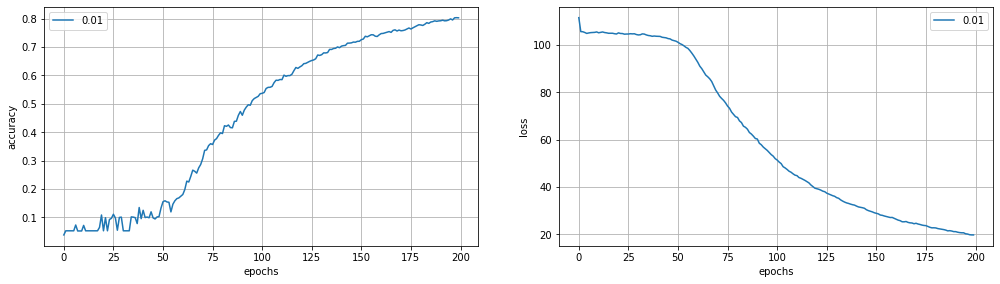

In [11]:
# passing dictionary but running with both users no partial
from IPython.core.pylabtools import figsize
# results with range(args.num_users)
import matplotlib.pyplot as plt
figures, axes = plt.subplots(nrows=1,ncols=2,figsize = (15,5))
figures.tight_layout(pad = 5)
axes[0].plot(train_accuracy,label=str(args.lr))
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('accuracy')
axes[0].legend()
axes[0].grid()
axes[1].plot(train_loss,label=str(args.lr))
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('loss')
axes[1].legend()
axes[1].grid()
filename = 'femnist'+args.optimizer+'_'+str(args.partial_users)+'of'+str(args.num_users)
figures.savefig(filename)

In [12]:
import csv
filename = args.optimizer+'_'+str(args.partial_users)+'of'+str(args.num_users)
with open(filename+'.csv', 'w') as f: 
    write = csv.writer(f) 
    write.writerow(train_accuracy) 
    write.writerow(train_loss)